# MIMIC-III and Support2Cls Data

## MIMIC-III

In [42]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import importlib
import utils
importlib.reload(utils)

from utils import eval_model, perturb_labels_fp, update_model_feedback, make_gaussian_data

%matplotlib inline

In [43]:
def load_mimiciii_data():
    df_adult = pd.read_csv('adult_icu.gz', compression='gzip')
    
    train_cols = [
    'age', 'first_hosp_stay', 'first_icu_stay', 'eth_asian',
    'eth_black', 'eth_hispanic', 'eth_other', 'eth_white',
    'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_NEWBORN',
    'admType_URGENT', 'heartrate_min', 'heartrate_max', 'heartrate_mean',
    'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max',
    'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean',
    'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min',
    'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean',
    'glucose_min', 'glucose_max', 'glucose_mean', 'aniongap', 'albumin',
    'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
    'hematocrit', 'hemoglobin', 'lactate', 'magnesium', 'phosphate',
    'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc']
    
    label = 'mort_icu'
    X_df = df_adult[train_cols]
    y_df = df_adult[label]
    
    dataset = {
    'problem': 'classification',
    'X': X_df,
    'y': y_df,
    'd_name': 'mimiciii',
    }
    
    return dataset

In [44]:
def train_update_loop(model_fn, x, y, test_size, update_size, names, num_updates, seeds):
    seeds = np.arange(10)

    rates = {name: {update: {"initial": [], "updated": []} for update in num_updates} for name in names}

    for seed in seeds:
        np.random.seed(seed)

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, stratify=y)
        x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)

        model = model_fn()
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
        y_score = model.decision_function(x_test)
        initial_auc = roc_auc_score(y_test, y_score)
        
        for update in num_updates:
            new_model, _ = update_model_feedback(model, x_update, y_update, None, None, update)

            y_pred = new_model.predict(x_test)
            updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
            y_score = new_model.decision_function(x_test)
            updated_auc = roc_auc_score(y_test, y_score)

            rates["fpr"][update]["initial"].append(initial_fpr)
            rates["tpr"][update]["initial"].append(initial_tpr)
            rates["fnr"][update]["initial"].append(initial_fnr)
            rates["tnr"][update]["initial"].append(initial_tnr)
            rates["auc"][update]["initial"].append(initial_auc)

            rates["fpr"][update]["updated"].append(updated_fpr)
            rates["tpr"][update]["updated"].append(updated_tpr)
            rates["fnr"][update]["updated"].append(updated_fnr)
            rates["tnr"][update]["updated"].append(updated_tnr)
            rates["auc"][update]["updated"].append(updated_auc)
            
    return rates

In [45]:
def convert_to_dataframe(rates, names, num_updates):
    data = {"rate": [], "type": [], "num_updates": [], "time": []}

    for name in names:
        for update in num_updates:
            data["rate"] += rates[name][update]["initial"]
            data["type"] += [name] * len(rates[name][update]["initial"])
            data["num_updates"] += [update] * len(rates[name][update]["initial"])
            data["time"] += ["initial"] * len(rates[name][update]["initial"])

            data["rate"] += rates[name][update]["updated"]
            data["type"] += [name] * len(rates[name][update]["updated"])
            data["num_updates"] += [update] * len(rates[name][update]["updated"])
            data["time"] += ["updated"] * len(rates[name][update]["updated"])
            
            
    return pd.DataFrame(data)

In [46]:
def lr_wrapper(class_weight):
    def lr():
        return linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log", class_weight=class_weight)
    
    return lr

In [47]:
def svm_wrapper(class_weight):
    def svm():
        return linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="hinge", class_weight=class_weight)
    
    return svm

In [48]:
def plot_rate(data, rate_type, model_name):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    sns.lineplot(x="num_updates", y="rate", hue="time", style="time", marker="o", data=data.loc[data["type"] == rate_type], err_style="band", ax=ax, ci="sd")
    # sns.boxplot(x="num_updates", y="rate", hue="time", data=data.loc[data["type"] == "fpr"], ax=ax)
    # sns.swarmplot(x="type", y="rate", hue="time", data=data, color=".25", ax=ax)
    ax.set_xlabel("Num Updates", size=20)
    ax.set_ylabel(rate_type.upper(), size=20)
    ax.set_title("Updated {}s".format(rate_type.upper()), size=26)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    fig.savefig("figures/real_data/mimic_{}_{}.png".format(model_name, rate_type), dpi=300)

In [49]:
num_updates = [1, 10, 25, 50, 75, 100]
names = ["fpr", "tpr", "fnr", "tnr", "auc"]
seeds = 100

In [50]:
data = load_mimiciii_data()
x = data["X"].to_numpy()
y = data["y"].to_numpy()

In [51]:
prop_0 = np.sum(y == 0) / float(len(y))
prop_1 = np.sum(y == 1) / float(len(y))

weight_0 = float(len(y)) / (2 * np.sum(y == 0))
weight_1 = float(len(y)) / (2 * np.sum(y == 1))

print("Positive Samples: {}".format(prop_1))
print("Negative Samples: {}".format(prop_0))

Positive Samples: 0.09839842035980693
Negative Samples: 0.901601579640193


### Logistic Regression

#### Balanced

In [52]:
model_name = "lr_balanced"
model_fn = lr_wrapper({0: weight_0, 1: weight_1})
rates = train_update_loop(model_fn, x, y, test_size=0.6, update_size=0.5, names=names, num_updates=num_updates, seeds=seeds)

In [53]:
data = convert_to_dataframe(rates, names, num_updates)

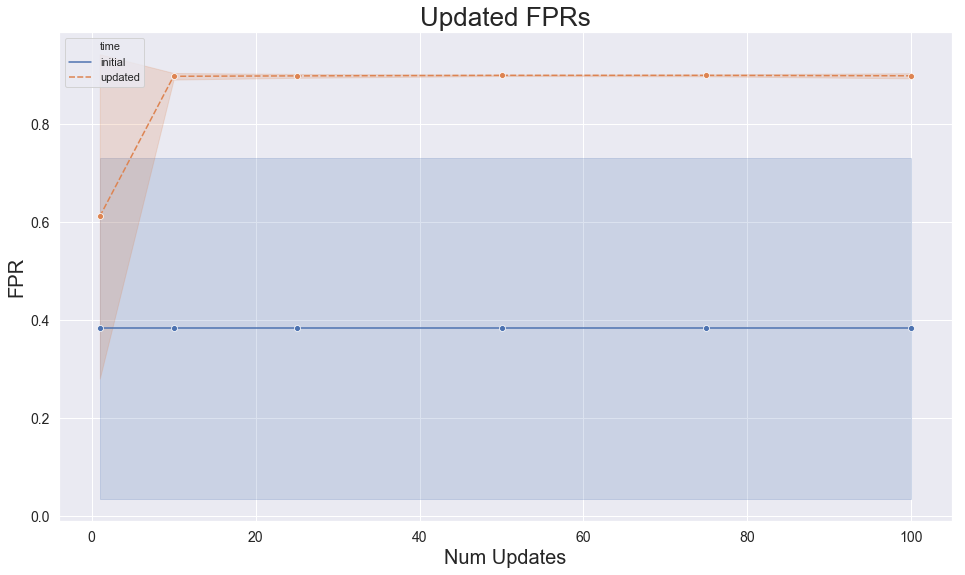

In [54]:
rate_type = "fpr"
plot_rate(data, rate_type, model_name)

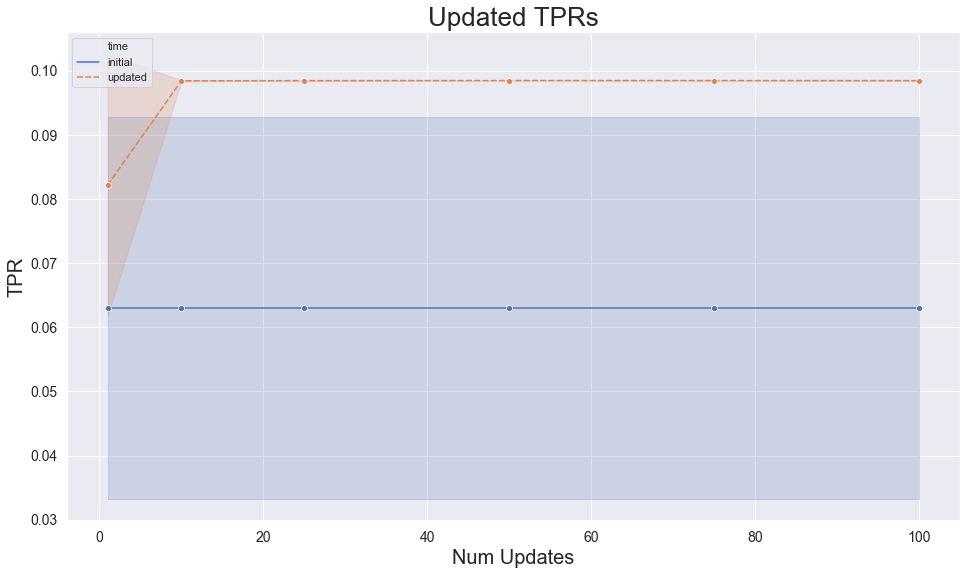

In [55]:
rate_type = "tpr"
plot_rate(data, rate_type, model_name)

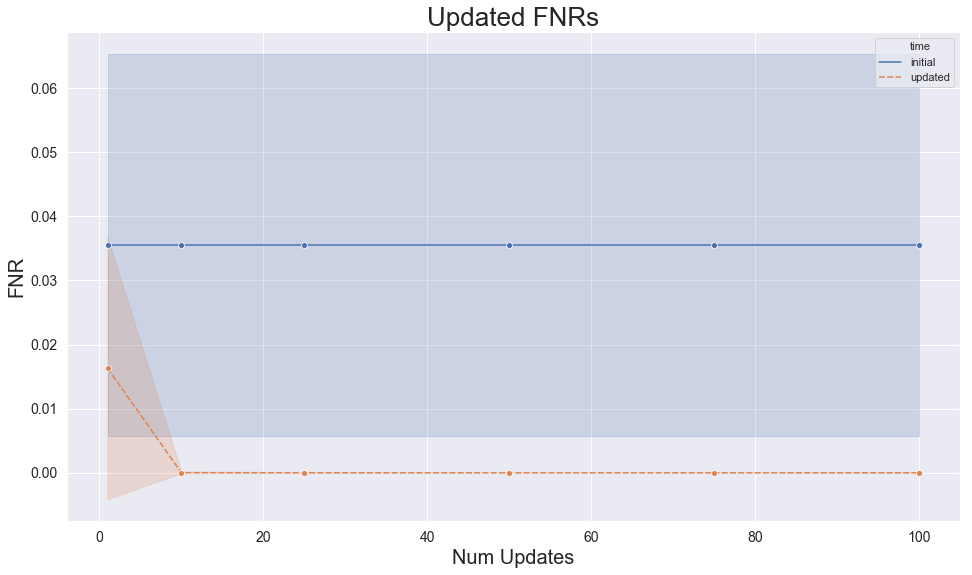

In [56]:
rate_type = "fnr"
plot_rate(data, rate_type, model_name)

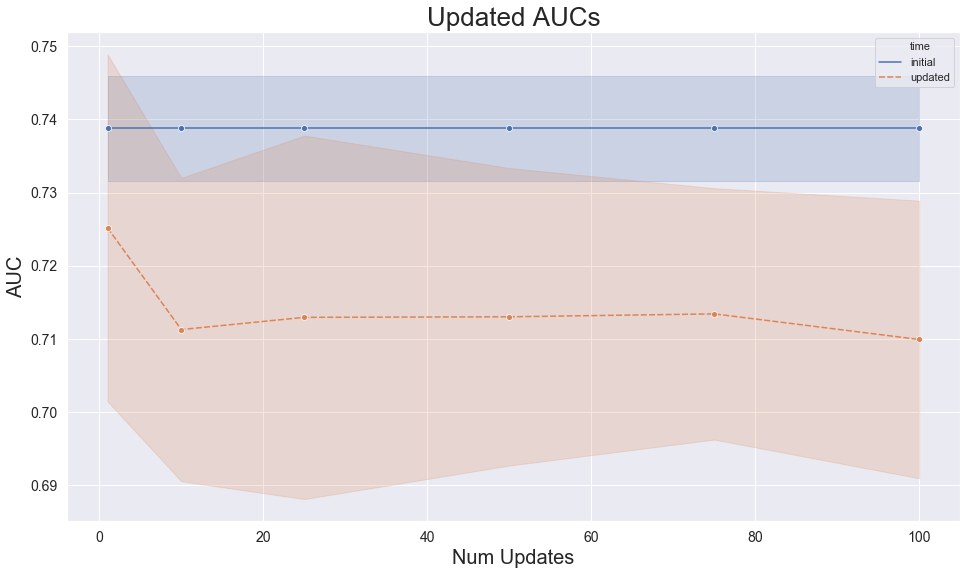

In [64]:
rate_type = "auc"
plot_rate(data, rate_type, model_name)

#### Unbalanced

In [57]:
model_name = "lr_unbalanced"
model_fn = lr_wrapper(None)
rates = train_update_loop(model_fn, x, y, test_size=0.6, update_size=0.5, names=names, num_updates=num_updates, seeds=seeds)

In [58]:
data = convert_to_dataframe(rates, names, num_updates)

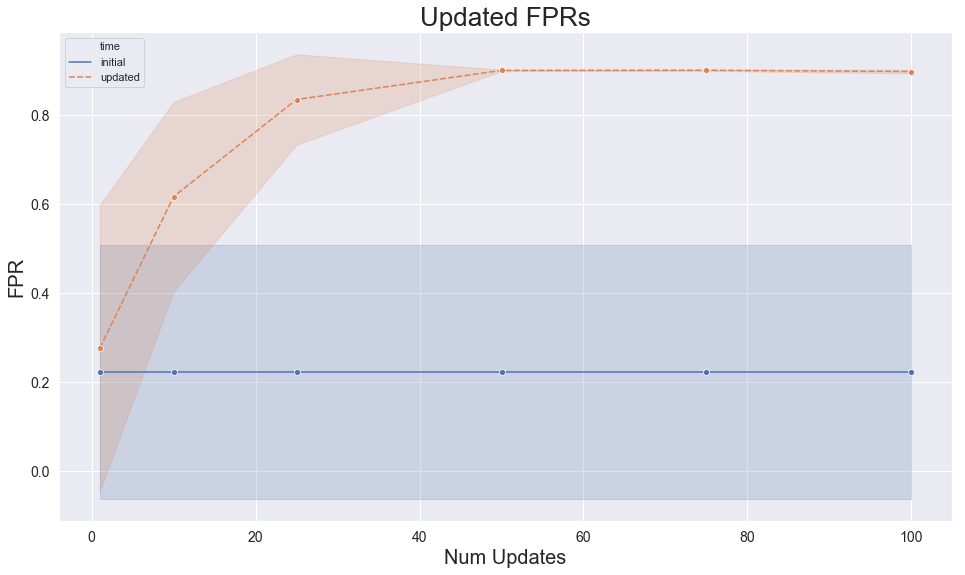

In [59]:
rate_type = "fpr"
plot_rate(data, rate_type, model_name)

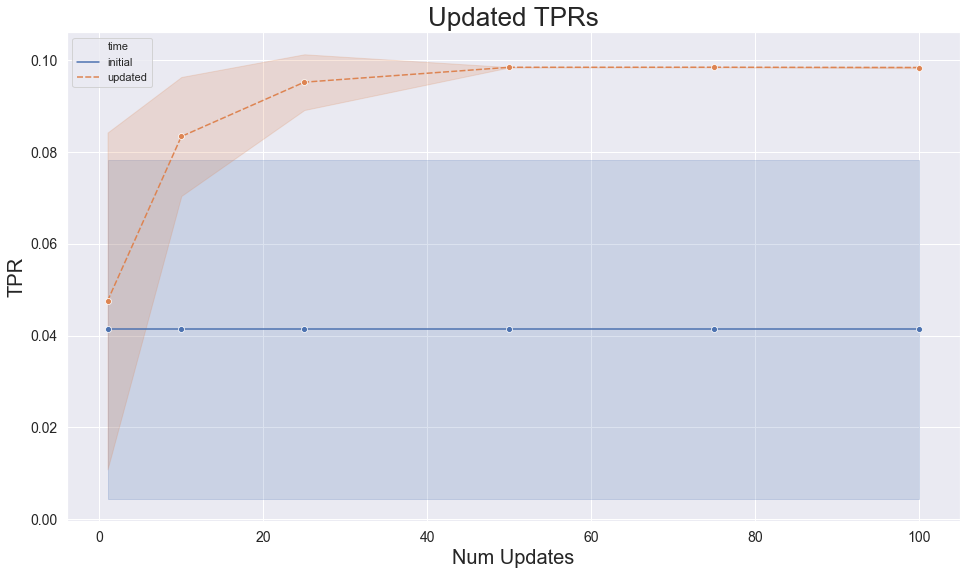

In [60]:
rate_type = "tpr"
plot_rate(data, rate_type, model_name)

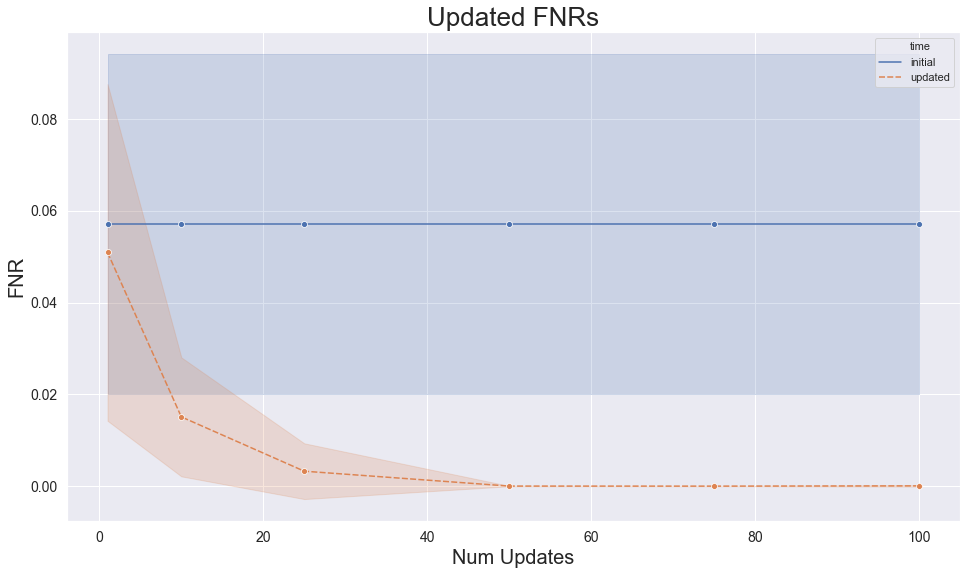

In [20]:
rate_type = "fnr"
plot_rate(data, rate_type, model_name)

**Conclusion:** here is that it takes much fewer updates to achieve the highest FPR possible when dealing with highly imbalanced data, regardless if the model used tries to balance the classes by reweighting samples.

### SVM

#### Balanced

In [61]:
model_name = "svm_balanced"
model_fn = svm_wrapper({0: weight_0, 1: weight_1})
rates = train_update_loop(model_fn, x, y, test_size=0.6, update_size=0.5, names=names, num_updates=num_updates, seeds=seeds)

In [62]:
data = convert_to_dataframe(rates, names, num_updates)

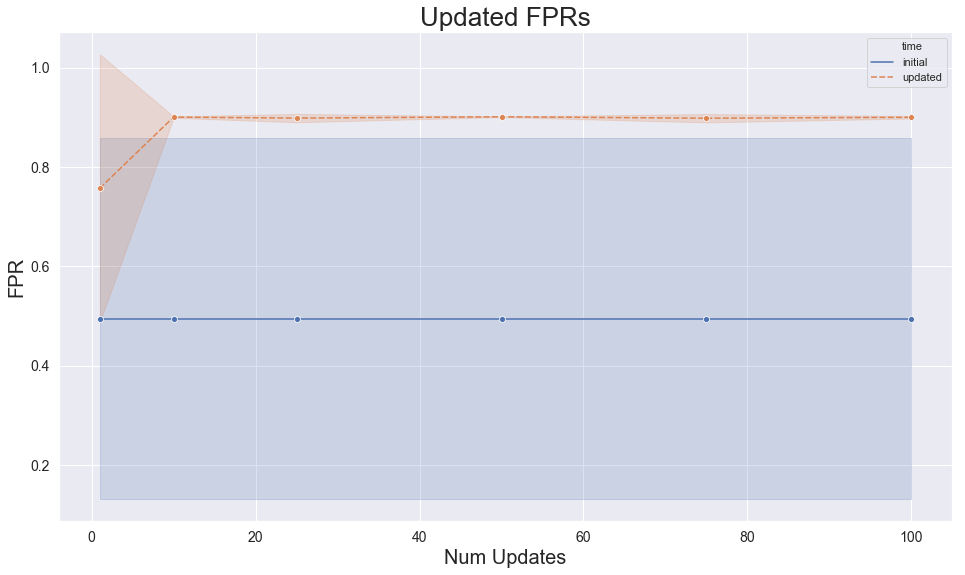

In [63]:
rate_type = "fpr"
plot_rate(data, rate_type, model_name)

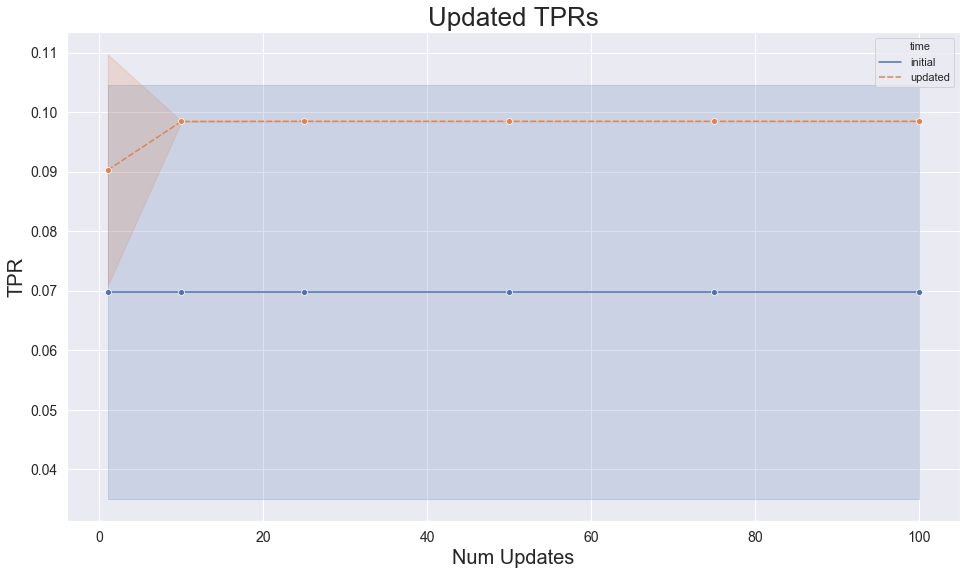

In [24]:
rate_type = "tpr"
plot_rate(data, rate_type, model_name)

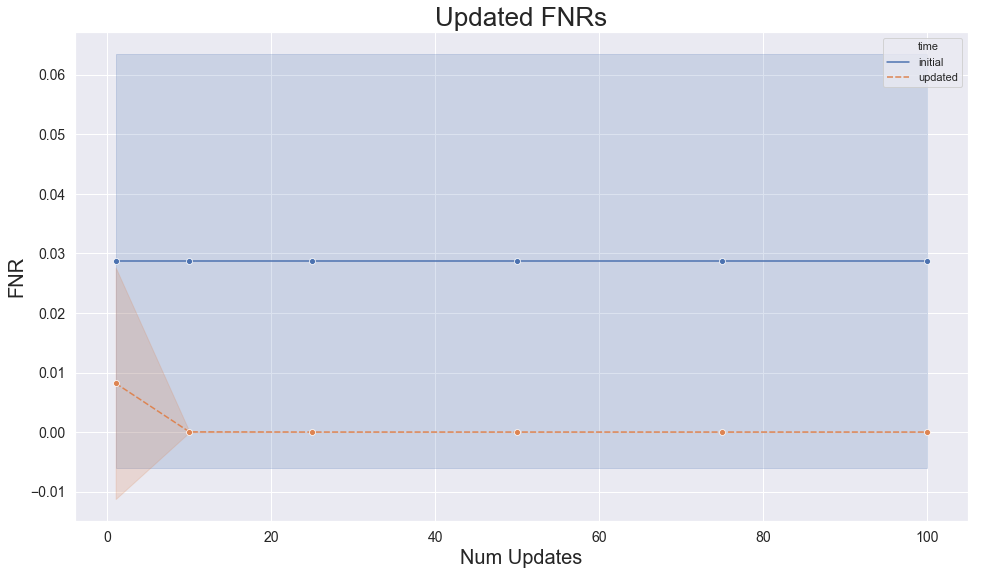

In [25]:
rate_type = "fnr"
plot_rate(data, rate_type, model_name)

#### Unbalanced

In [26]:
model_name = "svm_unbalanced"
model_fn = svm_wrapper(None)
rates = train_update_loop(model_fn, x, y, test_size=0.6, update_size=0.5, names=names, num_updates=num_updates, seeds=seeds)

In [27]:
data = convert_to_dataframe(rates, names, num_updates)

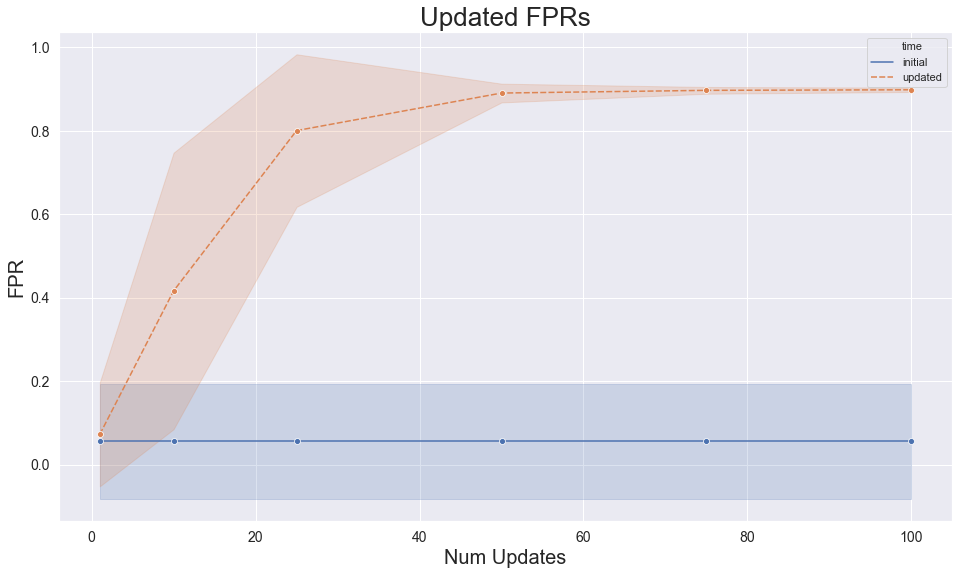

In [28]:
rate_type = "fpr"
plot_rate(data, rate_type, model_name)

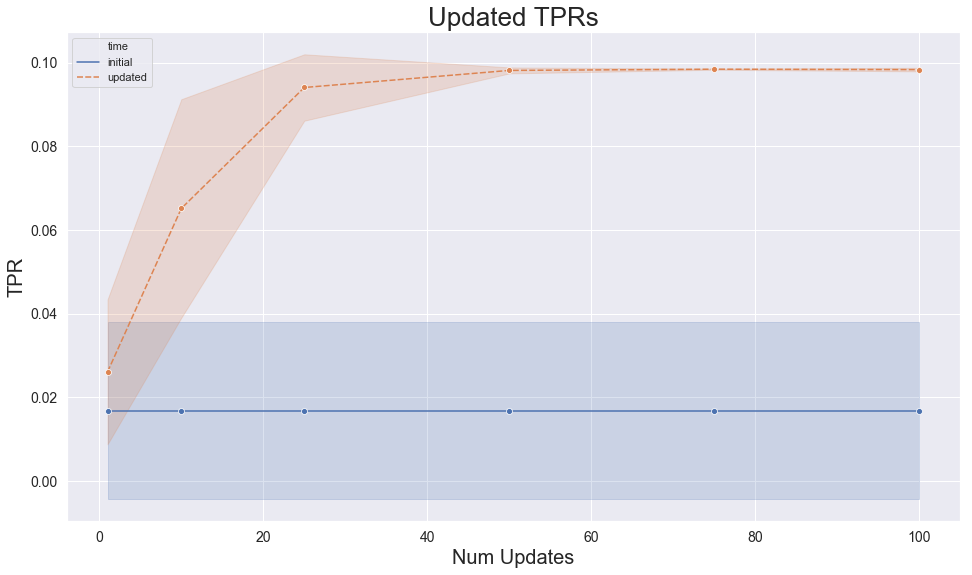

In [29]:
rate_type = "tpr"
plot_rate(data, rate_type, model_name)

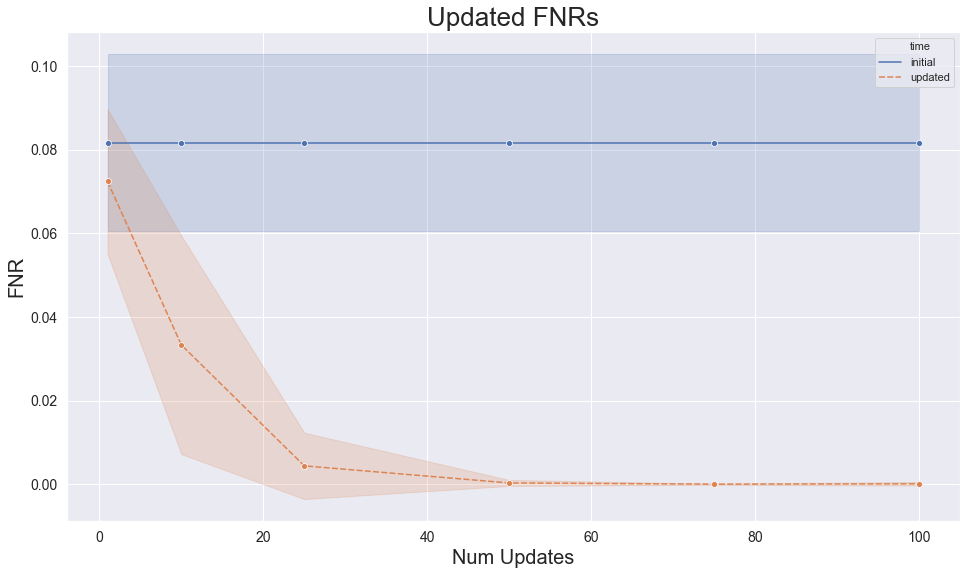

In [30]:
rate_type = "fnr"
plot_rate(data, rate_type, model_name)